In [1]:
from bs4 import BeautifulSoup
import requests
import time, os
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC


from urllib.parse import urljoin

chromedriver = "/usr/bin/chromedriver" # path to the chromedriver executable
os.environ["webdriver.chrome.driver"] = chromedriver

In [2]:
url = 'https://www.boxofficemojo.com/year/2020/?ref_=bo_yl_table_1'
response = requests.get(url)
page = response.text

soup = BeautifulSoup(page, 'lxml')
table = soup.find_all('table')
df = pd.read_html(str(table))[0]
df.drop(columns=['Genre', 'Budget', 'Running Time'], inplace=True)

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


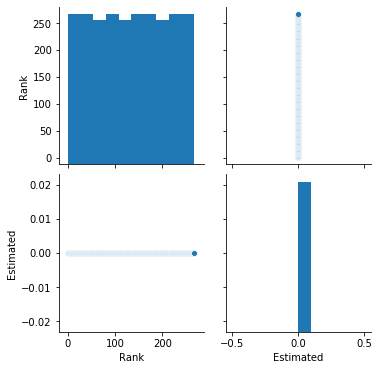

In [3]:
sns.pairplot(df)

In [4]:
import dateutil.parser

def money_to_int(moneystring):
    if moneystring != None:
        moneystring = moneystring.replace('$', '').replace(',', '')
    else:
        moneystring = 'None'
    return int(moneystring)

def runtime_to_minutes(runtimestring):
    if runtimestring != None:
        runtime = runtimestring.split()
    try:
        minutes = int(runtime[0])*60 + int(runtime[2])
        return minutes
    except:
        return None

def to_date(datestring):
    date = dateutil.parser.parse(datestring)
    return date

In [5]:
def get_movie_value(soup, field_name):
    
    '''Grab a value from Box Office Mojo HTML
    
    Takes a string attribute of a movie on the page and returns the string in
    the next sibling object (the value for that attribute) or None if nothing is found.
    '''
    
    obj = soup.find(text=re.compile(field_name))
    if not obj: 
        return None
    
    # this works for most of the values
    next_element = obj.findNext()
    if next_element:
        return next_element.text 
    else:
        return None

In [6]:
def get_movie_dict(link):
    '''
    From BoxOfficeMojo link stub, request movie html, parse with BeautifulSoup, and
    collect 
        - title 
        - domestic gross
        - runtime 
        - MPAA rating
        - full release date
    Return information as a dictionary.
    '''
    
    base_url = 'https://www.boxofficemojo.com'
    
    #Create full url to scrape
    url = base_url + link
    
    #Request HTML and parse
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page,"lxml")

    
    headers = ['movie_title', 'domestic_total_gross',
               'runtime_minutes', 'rating', 'release_date', 'budget']
    
    #Get title
    title_string = soup.find('title').text
    title = title_string.split('-')[0].strip()
    #Get domestic gross
    try:
        raw_domestic_total_gross = (soup.find(class_='mojo-performance-summary-table')
                                    .find_all('span', class_='money')[0]
                                    .text
                               )
    except:
        raw_domestic_total_gross = float("NaN")
    
    if raw_domestic_total_gross is None:
        print('This is NaN')
        domestic_total_gross = float("NaN")
    else:
        domestic_total_gross = money_to_int(raw_domestic_total_gross)

    #Get runtime
    raw_runtime = get_movie_value(soup,'Running')
    if raw_runtime != None:
        runtime = runtime_to_minutes(raw_runtime)
    
    #Get rating
    rating = get_movie_value(soup,'MPAA')

    #Get release date
    if '-' in get_movie_value(soup, 'Release Date'):
        raw_release_date = get_movie_value(soup,'Release Date').split('-')[0]
    elif '(' in get_movie_value(soup, 'Release Date'):
        raw_release_date = get_movie_value(soup,'Release Date').split('(')[0]
    else:
        raw_release_date = get_movie_value(soup,'Release Date').split('(')[0]
    release_date = to_date(raw_release_date)
    


    # Get budget alt 
    raw_budget = get_movie_value(soup,'Budget')
    if raw_budget is None:
        budget = raw_budget
    else:
        budget = money_to_int(raw_budget)

    #Create movie dictionary and return
    movie_dict = dict(zip(headers,[title,
                                domestic_total_gross,
                                runtime,
                                rating, 
                                release_date,
                                budget]))

    return movie_dict

In [7]:
def get_movie_dict2(link):
    
    base_url = 'https://www.rottentomatoes.com'
    
    #Create full url to scrape
    url = base_url + link
    
    #Request HTML and parse
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page,"lxml")

    
    headers = ['Movie Title', 'Tomatometer', 'Tomatometer Count',
               'Audience Score', 'Audience Count']
    
    #Get title
    title_string = soup.find('title').text
    title = title_string.split('(')[0]
    
    #Get ratings
    try:
        tomato_rating_div = soup.find('div', class_='mop-ratings-wrap__half')
        tomato_score = (tomato_rating_div
                        .find(class_='mop-ratings-wrap__percentage')
                        .text
                        .strip()
                        .split('%')[0]
                       )   
        tomato_score = int(tomato_score) * 0.01
    except:
        tomato_score = None
        
    try: 
        audience_rating_div = soup.find('div', class_= 'mop-ratings-wrap__half audience-score')
        audience_score = (audience_rating_div
                            .find('span', class_='mop-ratings-wrap__percentage')
                            .text
                            .strip()
                            .split('%')[0]
                           )
        audience_score = int(audience_score) * 0.01
    except:
        audience_score = None
        
    try:
        tomato_count_div = soup.find('div', class_='mop-ratings-wrap__review-totals')
        tomato_count = (tomato_rating_div.find('small', class_='mop-ratings-wrap__text--small')).text.strip()
        tomato_count = money_to_int(tomato_count)
    except:
        tomato_count = None
    try:
        audience_count_div = soup.find('div', class_='mop-ratings-wrap__review-totals mop-ratings-wrap__review-totals--not-released')
        


        audience_count = (audience_count_div
                          .find('strong',
                                class_='mop-ratings-wrap__text--small')
                          .text
                          .strip()
                          .split(': ')[-1]
                         )
        audience_count = money_to_int(audience_count)
    except:
        audience_count = None            


#     #Create movie dictionary and return
    movie_dict = dict(zip(headers, [
                            title, 
                            tomato_score, 
                            tomato_count,
                            audience_score, 
                            audience_count]))
    
    return movie_dict

In [8]:
tom_dicts = []

tomato_links = [
        'bad_boys_for_life',
        '1917_2019',
        'sonic_the_hedgehog_2020',
        'jumanji_the_next_level',
        'star_wars_the_rise_of_skywalker',
        'birds_of_prey_2020',
        'dolittle',
        'little_women_2019',
        'the_invisible_man_2020',
        'the_call_of_the_wild_2020',
        'onward',
        'knives_out',
        'frozen_ii',
        'spies_in_disguise',
        'the_gentlemen',
        'just_mercy',
        'parasite_2019',
        'fantasy_island_2020',
        'uncut_gems',
        'like_a_boss',
        'the_grudge_2020',
        'the_photograph_2020',
        'underwater_2020',
        'the_turning_2020',
        'gretel_and_hansel',
        'my_hero_academia_hero_heroes_rising',
        'bombshell_2019',
        'the_way_back_2020',
        'brahms_the_boy_ii',
        'jojo_rabbit',
        'impractical_jokers_the_movie',
        'ford_v_ferrari',
        'emma_2020',
        'bloodshot_2020',
        'i_still_believe',
        'downhill_2020',
        'weathering_with_you',
        'cats_2019',
        'the_hunt_2019',
        'the_rhythm_section',
        'a_beautiful_day_in_the_neighborhood',
        'richard_jewell',
        'portrait_of_a_lady_on_fire',
        '2020_oscar_nominated_shorts_animation',
        'queen_and_slim',
        '2020_oscar_nominated_shorts_live_action',
        'the_last_full_measure',
        'ip_man_4_the_finale',
        'the_wretched_2020',
        'joker_2019',
]

for link in tomato_links:
    tom_dicts.append(get_movie_dict2('/m/{}'.format(link)))
    
tom_dicts

[{'Movie Title': 'Bad Boys for Life ',
  'Tomatometer': 0.77,
  'Tomatometer Count': 254,
  'Audience Score': 0.96,
  'Audience Count': 42943},
 {'Movie Title': '1917 ',
  'Tomatometer': 0.89,
  'Tomatometer Count': 432,
  'Audience Score': 0.88,
  'Audience Count': 30468},
 {'Movie Title': 'Sonic the Hedgehog ',
  'Tomatometer': 0.63,
  'Tomatometer Count': 227,
  'Audience Score': 0.93,
  'Audience Count': 19411},
 {'Movie Title': 'Jumanji: The Next Level ',
  'Tomatometer': 0.72,
  'Tomatometer Count': 236,
  'Audience Score': 0.87,
  'Audience Count': 35735},
 {'Movie Title': 'Star Wars: The Rise of Skywalker ',
  'Tomatometer': 0.51,
  'Tomatometer Count': 486,
  'Audience Score': 0.86,
  'Audience Count': 98236},
 {'Movie Title': 'Birds of Prey ',
  'Tomatometer': 0.78,
  'Tomatometer Count': 397,
  'Audience Score': 0.78,
  'Audience Count': 15708},
 {'Movie Title': 'Dolittle ',
  'Tomatometer': 0.14,
  'Tomatometer Count': 223,
  'Audience Score': 0.76,
  'Audience Count': 1152

In [9]:
mojo_links = [ 
        'rl1182631425',
        'rl2969994753',
        'rl4244997633',
        'rl755467777',
        'rl3305145857',
        'rl3640886785',
        'rl2164295169',
        'rl218596865',
        'rl50628097',
        'rl2533524993',
        'rl3433267713',
        'rl3204875777',
        'rl2424210945',
        'rl1333691905',
        'rl3473442305',
        'rl419792385',
        'rl1258849793',
        'rl1611040257',
        'rl3825763841',
        'rl4278486529',
        'rl1745126913',
        'rl1655931393',
        'rl302548481',
        'rl3020195329',
        'rl3842541057',
        'rl867926529',
        'rl2550760961',
        'rl4127819265',
        'rl2567538177',
        'rl2030601729',
        'rl2998501889',
        'rl990348801',
        'rl3221784065',
        'rl235374081',
        'rl1628014081',
        'rl2611249665',
        'rl3669066241',
        'rl2684847617',
        'rl1459979777',
        'rl3775038977',
        'rl2651096577',
        'rl2903213569',
        'rl1325958657',
        'rl615875073'
        'rl50824705',
        'rl537298433',
        'rl1617987073',
        'rl1386316289',
        'rl716997121',
        'rl252151297'
        ]

dicts = []

for link in mojo_links:
    dicts.append(get_movie_dict('/release/{}/'.format(link)))

dicts

[{'movie_title': 'Bad Boys for Life',
  'domestic_total_gross': 204417855,
  'runtime_minutes': 124,
  'rating': 'R',
  'release_date': datetime.datetime(2020, 1, 17, 0, 0),
  'budget': 90000000},
 {'movie_title': '1917',
  'domestic_total_gross': 159227644,
  'runtime_minutes': 119,
  'rating': 'R',
  'release_date': datetime.datetime(2019, 12, 25, 0, 0),
  'budget': 95000000},
 {'movie_title': 'Sonic the Hedgehog',
  'domestic_total_gross': 146066470,
  'runtime_minutes': 99,
  'rating': 'PG',
  'release_date': datetime.datetime(2020, 2, 14, 0, 0),
  'budget': 85000000},
 {'movie_title': 'Jumanji: The Next Level',
  'domestic_total_gross': 316831246,
  'runtime_minutes': 123,
  'rating': 'PG-13',
  'release_date': datetime.datetime(2019, 12, 13, 0, 0),
  'budget': 125000000},
 {'movie_title': 'Star Wars: Episode IX',
  'domestic_total_gross': 515202542,
  'runtime_minutes': 142,
  'rating': 'PG-13',
  'release_date': datetime.datetime(2019, 12, 20, 0, 0),
  'budget': 275000000},
 {'m

In [10]:
df1 = pd.DataFrame.from_dict(tom_dicts)
df2 = pd.DataFrame.from_dict(dicts)
df1


,Movie Title,Tomatometer,Tomatometer Count,Audience Score,Audience Count
0,Bad Boys for Life,0.77,254.0,0.96,42943.0
1,1917,0.89,432.0,0.88,30468.0
2,Sonic the Hedgehog,0.63,227.0,0.93,19411.0
3,Jumanji: The Next Level,0.72,236.0,0.87,35735.0
4,Star Wars: The Rise of Skywalker,0.51,486.0,0.86,98236.0
5,Birds of Prey,0.78,397.0,0.78,15708.0
6,Dolittle,0.14,223.0,0.76,11522.0
7,Little Women,0.94,397.0,0.92,18193.0
8,The Invisible Man,0.91,373.0,0.88,11898.0
9,The Call of the Wild,0.61,190.0,0.89,9360.0


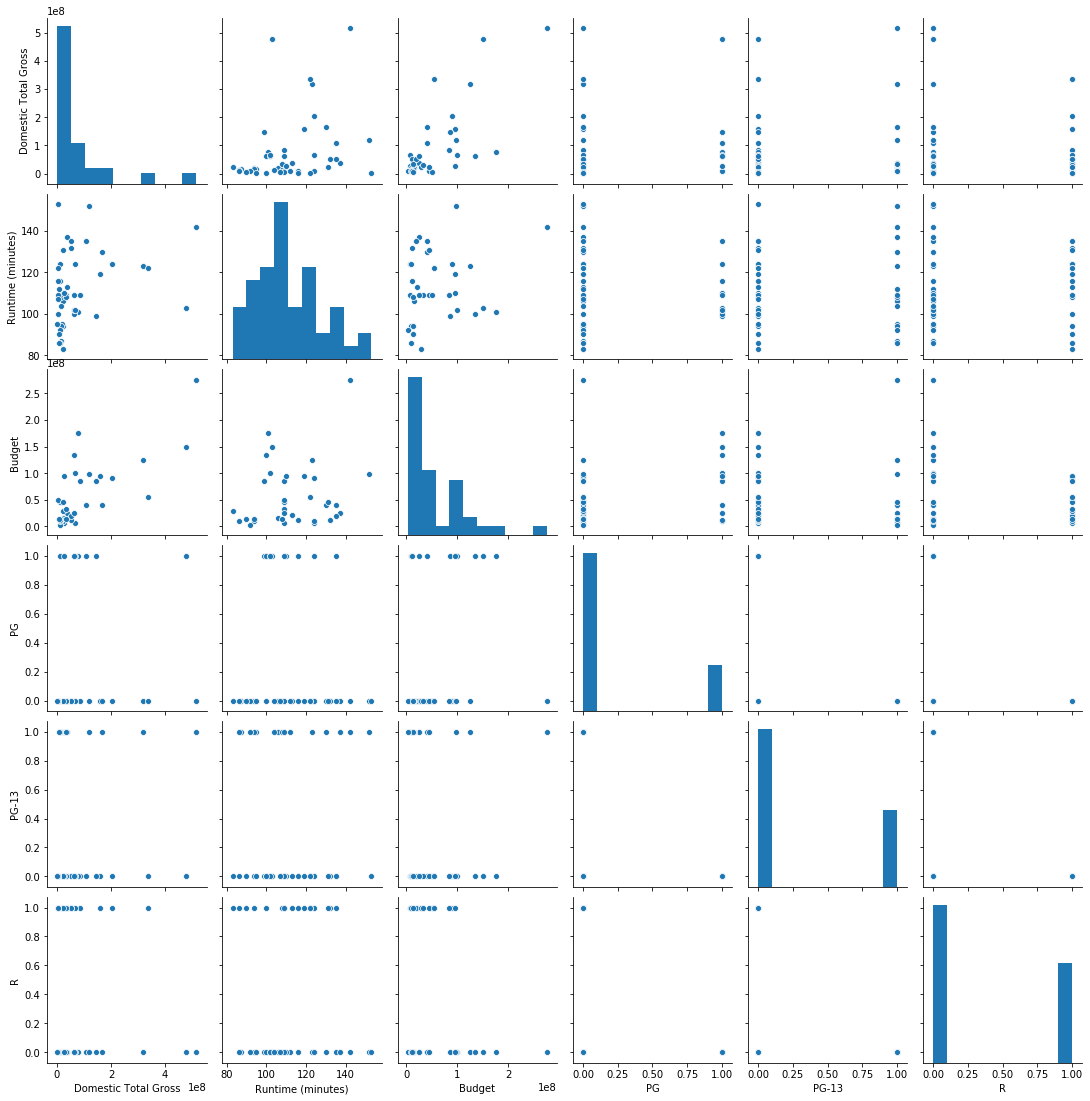

In [11]:
df2 = df2.rename(columns={"movie_title": 'Movie Title', 'domestic_total_gross': 'Domestic Total Gross', 'runtime_minutes': 'Runtime (minutes)', 'rating': 'Rating', 'release_date': 'Release Date', 'budget': 'Budget'})
df2

rating_one_hot = pd.get_dummies(df2['Rating'])
frames = [df2, rating_one_hot]

df_ratings = df2.merge(rating_one_hot, left_index=True, right_index=True).drop(columns='Rating')
sns.pairplot(df_ratings)

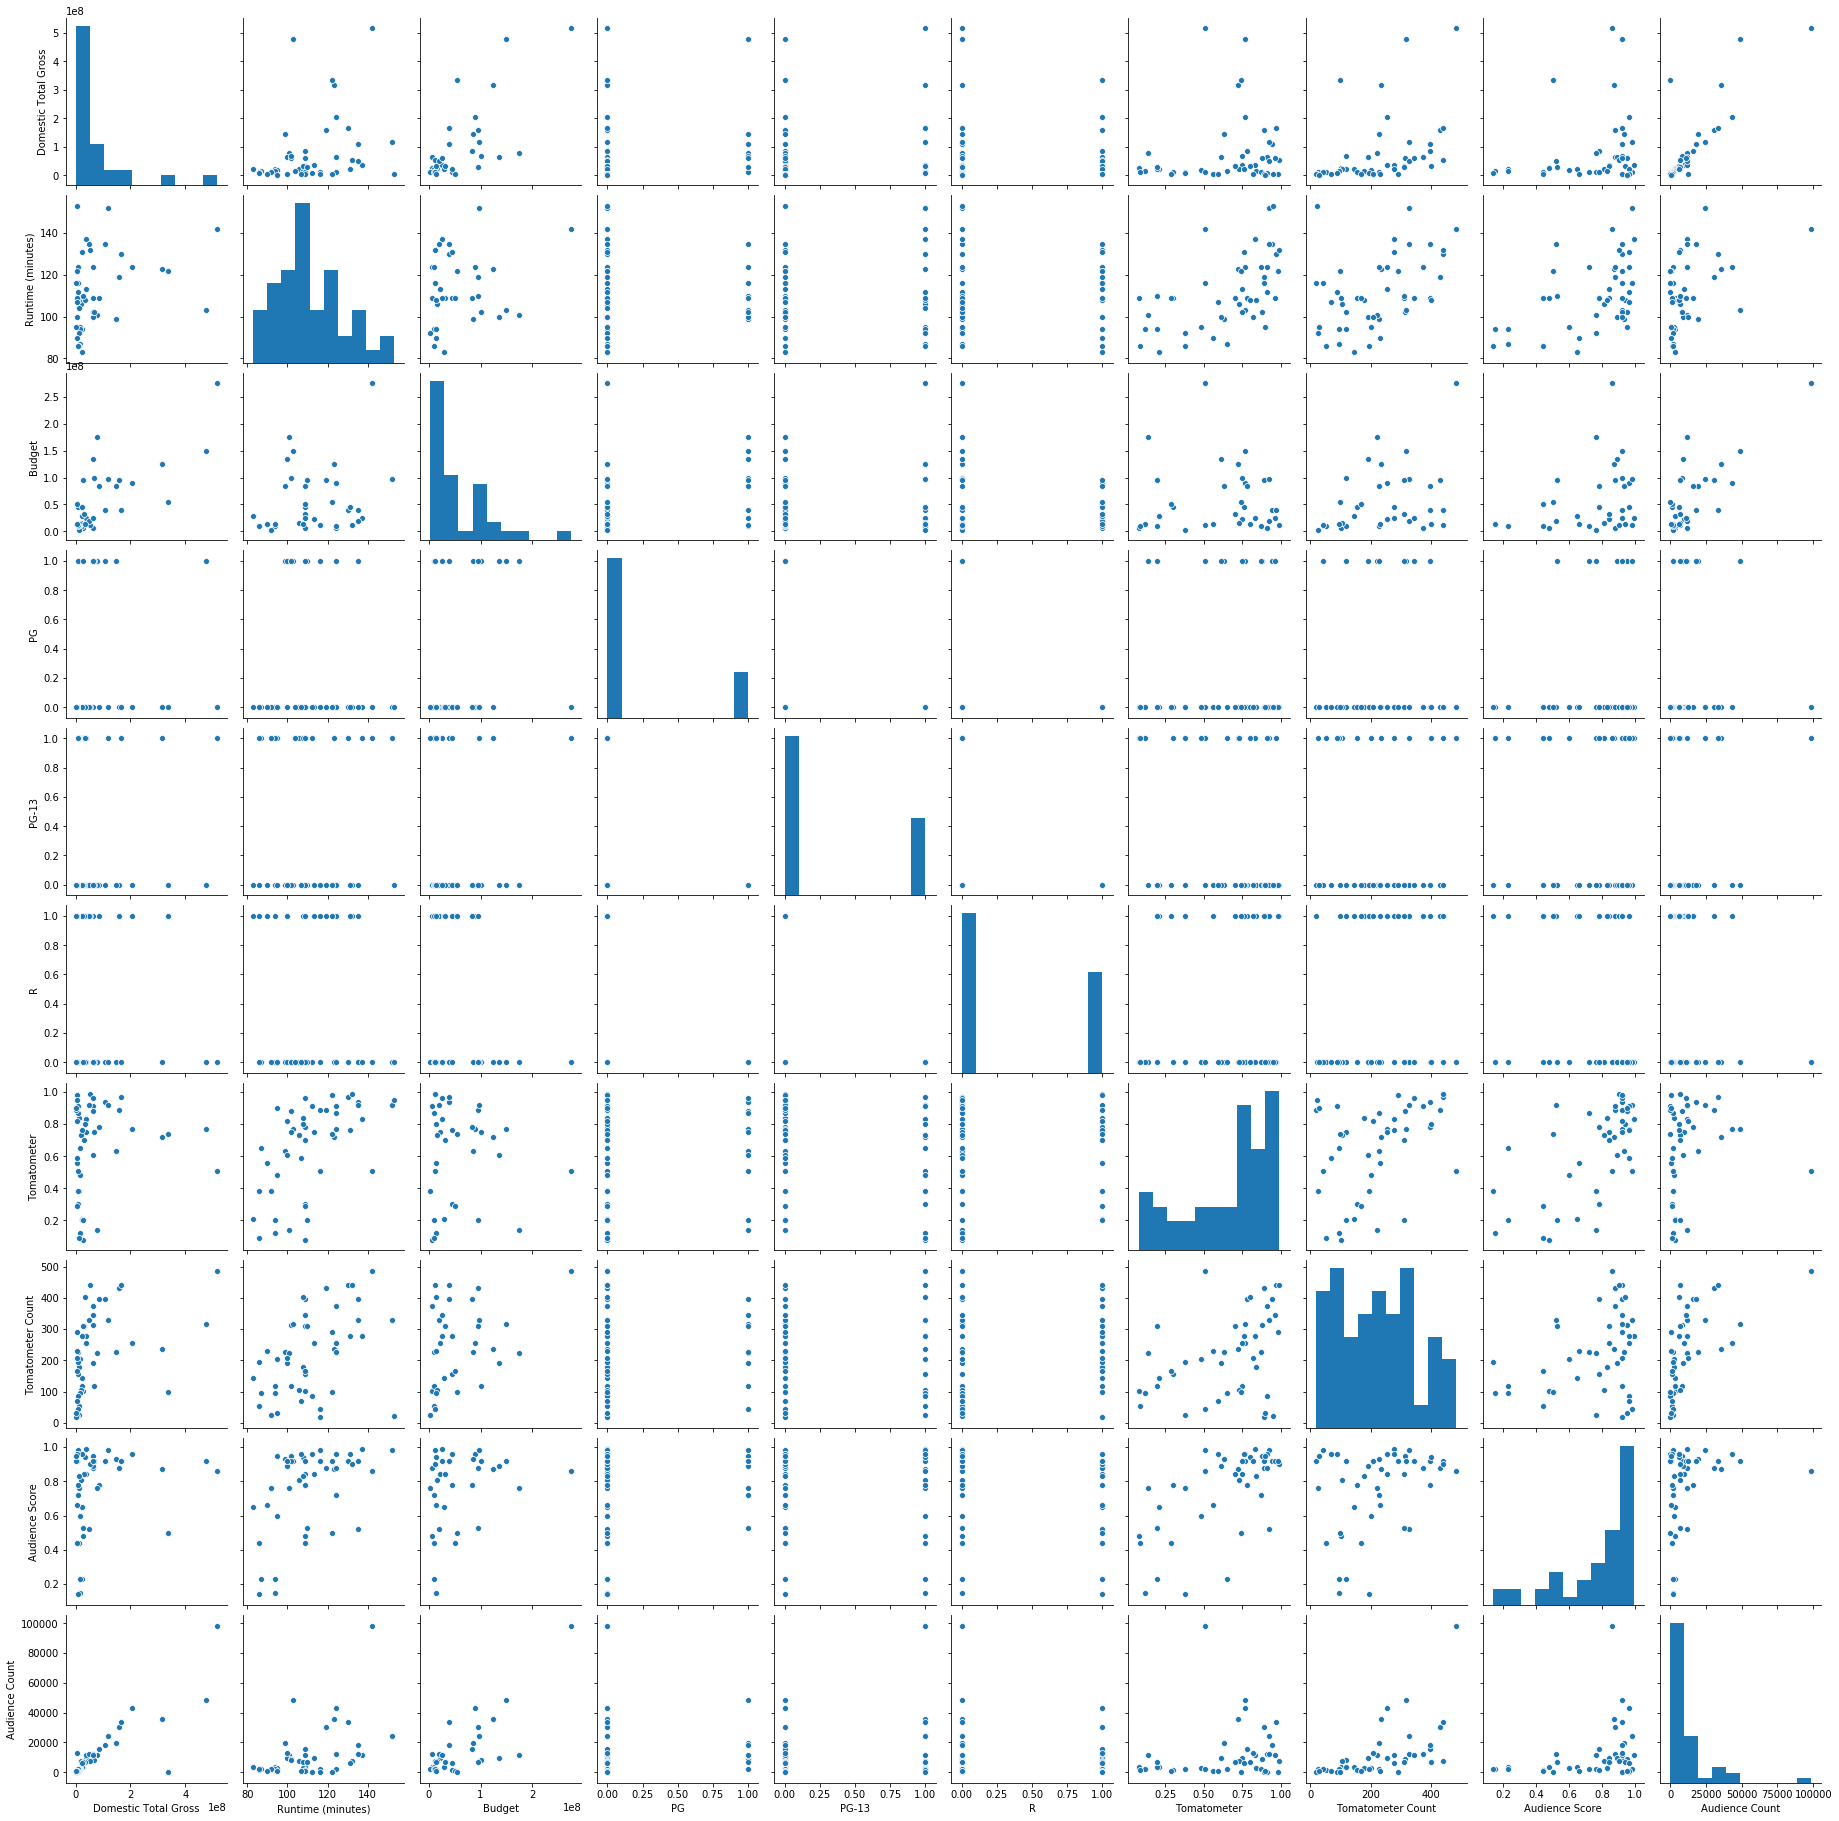

In [12]:
# df_ratings['Tomatometer Score'] = df1.iloc[df1['Tomatometer']]
df_ratings['Tomatometer'] = df1['Tomatometer'].astype(float)
df_ratings['Tomatometer Count'] = df1['Tomatometer Count'].astype(float)
df_ratings['Audience Score'] = df1['Audience Score'].astype(float)
df_ratings['Audience Count'] = df1['Audience Count'].astype(float)
df_ratings
# df5 = pd.merge(df1, df_ratings, on='Movie Title', how='outer')
sns.pairplot(df_ratings)

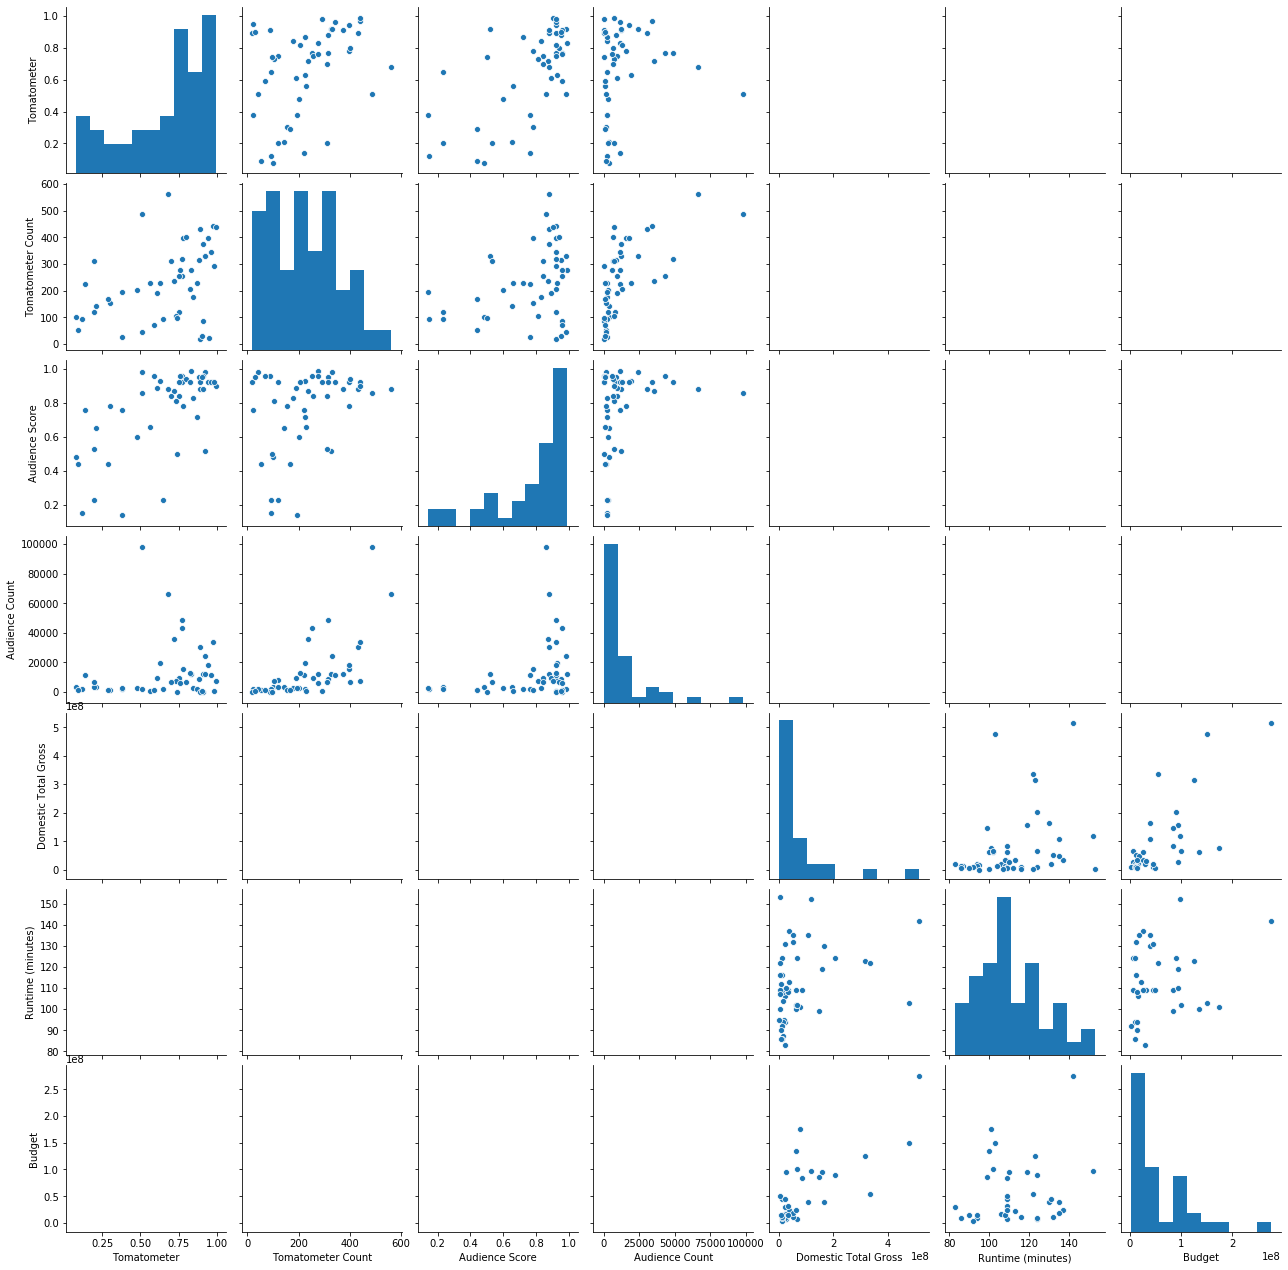

In [13]:
sns.pairplot(pd.concat([df1, df2]))

In [14]:
nona = df_ratings.dropna()
# .drop(columns=['Movie Title', 'Release Date'])
sns.heatmap(nona, vmin=-1, vmax=1)


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
base_url = 'https://www.rottentomatoes.com'
link = 


url = urljoin(base_url, link)

//*[@id="navbar"]/search-algolia/search-algolia-controls/input

uh....

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [ ]:
X = df_ratings.loc[df_ratings['Domestic Total Gross'], df_ratings['Budget']]
y = df_ratings['Tomatometer']

In [ ]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

In [ ]:
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()